In [5]:
pip install Keras


     |████████████████████████████████| 378kB 1.4MB/s eta 0:00:01    |█▊                              | 20kB 853kB/s eta 0:00:01
     |████████████████████████████████| 51kB 3.2MB/s eta 0:00:01
     |████████████████████████████████| 51kB 3.0MB/s eta 0:00:01
     |████████████████████████████████| 28.8MB 2.9MB/s eta 0:00:01
     |████████████████████████████████| 15.2MB 2.9MB/s eta 0:00:01
     |████████████████████████████████| 3.0MB 3.1MB/s eta 0:00:01
     |████████████████████████████████| 276kB 2.7MB/s eta 0:00:01
  Running setup.py install for pyyaml ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install torch

     |████████████████████████████████| 80.6MB 2.9MB/s eta 0:00:01     |██████▌                         | 16.3MB 2.6MB/s eta 0:00:26
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp38-none-any.whl size=7423 sha256=0e86cc1393097eddb4a21b38097bbf176b848a00dda75c3e738c844e530b67c9
  Stored in directory: /Users/maida/Library/Caches/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [145]:
pip install matplotlib

     |████████████████████████████████| 12.5MB 3.1MB/s eta 0:00:01
     |████████████████████████████████| 71kB 2.8MB/s eta 0:00:01
     |████████████████████████████████| 61kB 3.0MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [146]:
from math import nan
from future.utils import iteritems
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
#from utils import get_data, generate_output, guess_human, seed_sequence, get_embeddings, find_closest
import numpy as np
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("ner_dataset.csv", encoding= 'unicode_escape') 
data.head(672)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
667,NaN,Muslim,NNP,B-org
668,NaN,Brotherhood,NNP,I-org
669,NaN,as,IN,O
670,NaN,parts,NNS,O


In [3]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(data)
sentences = getter.sentences

In [150]:
words = list(set(data["Word"].values))
nrofWords = len(words)

ner_tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        ner_tags.append('unk')
    else:
        ner_tags.append(tag)
nrofTags = len(ner_tags)
print(ner_tags)

['O', 'B-org', 'I-org', 'B-art', 'I-art', 'B-geo', 'I-geo', 'B-per', 'B-gpe', 'B-eve', 'I-eve', 'I-gpe', 'B-tim', 'I-per', 'B-nat', 'I-tim', 'I-nat']


In [161]:
index_word = {w: i for i, w in enumerate(words)}
index_tag = {t: i for i, t in enumerate(ner_tags)}
idx2tag = {v: k for k, v in iteritems(index_tag)}
print(index_tag)
print(index_word)

{'O': 0, 'B-org': 1, 'I-org': 2, 'B-art': 3, 'I-art': 4, 'B-geo': 5, 'I-geo': 6, 'B-per': 7, 'B-gpe': 8, 'B-eve': 9, 'I-eve': 10, 'I-gpe': 11, 'B-tim': 12, 'I-per': 13, 'B-nat': 14, 'I-tim': 15, 'I-nat': 16}
{'aboriginal': 0, 'supplemental': 1, 'hepatitis': 2, 'environment-themed': 3, 'medium-term': 4, 'phase-out': 5, 'staunchly': 6, 'Sulik': 7, 'faithful': 8, 'Musical': 9, 'supplying': 10, 'Tayyip': 11, 'Simmons': 12, 'revisit': 13, 'wrathful': 14, 'scuffle': 15, 'Chiang': 16, 'US-India': 17, '1,31,000': 18, 'synagogue': 19, 'pronouncements': 20, 'Toufik': 21, 'Slumping': 22, 'patents': 23, 'conserve': 24, 'Amagasaki': 25, 'Ivo': 26, 'Valukevic': 27, 'mailed': 28, 'Contractors': 29, 'Novakatka': 30, 'nomination': 31, 'Witt': 32, 'city': 33, 'pyramid': 34, 'leisurely': 35, 'Ayar': 36, 'tore': 37, 'companions': 38, 'atolls': 39, 'Renate': 40, 'contract-style': 41, 'Fang': 42, 'self-government': 43, 'billboards': 44, 'outside': 45, 'unsuitable': 46, 'Tall': 47, 'Ports': 48, 'remark': 49,

In [152]:
maxlen = max([len(s) for s in sentences])
word_embedding_size = 17

X = [[index_word[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=nrofWords - 1)

y = [[index_tag[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=index_tag["O"])
y = [to_categorical(i, num_classes=nrofTags) for i in y]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

[[273]]
[array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)]


In [153]:
input = Input(shape=(maxlen,))

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=nrofWords+1, output_dim=word_embedding_size, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Dense(nrofTags, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
])

In [154]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [155]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 1, 17)             598043    
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 1, 128)            41984     
_________________________________________________________________
dense_17 (Dense)             (None, 1, 17)             2193      
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 17)             0         
Total params: 642,220
Trainable params: 642,220
Non-trainable params: 0
_________________________________________________________________


In [156]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=30,
                    validation_split=0.5, verbose=1)


Epoch 1/30
600/600 [==============================] - 4s 7ms/step - loss: 0.6226 - accuracy: 0.6878 - val_loss: 0.4862 - val_accuracy: 0.7185
Epoch 2/30
600/600 [==============================] - 3s 6ms/step - loss: 0.4767 - accuracy: 0.7094 - val_loss: 0.3840 - val_accuracy: 0.7185
Epoch 3/30
600/600 [==============================] - 3s 6ms/step - loss: 0.4494 - accuracy: 0.7094 - val_loss: 0.3629 - val_accuracy: 0.7185
Epoch 4/30
600/600 [==============================] - 3s 5ms/step - loss: 0.4432 - accuracy: 0.7094 - val_loss: 0.3548 - val_accuracy: 0.7185
Epoch 5/30
600/600 [==============================] - 3s 5ms/step - loss: 0.4399 - accuracy: 0.7094 - val_loss: 0.3502 - val_accuracy: 0.7185
Epoch 6/30
600/600 [==============================] - 3s 5ms/step - loss: 0.4376 - accuracy: 0.7092 - val_loss: 0.3470 - val_accuracy: 0.7185
Epoch 7/30
600/600 [==============================] - 3s 5ms/step - loss: 0.4365 - accuracy: 0.7066 - val_loss: 0.3443 - val_accuracy: 0.7185
Epoch 

In [166]:
test_pred = model.predict(X_test, verbose=1)

idx2tag = {i: w for w, i in index_tag.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)
print(index_tag.items())


300/300 [==============================] - 0s 1ms/step
dict_items([('O', 0), ('B-org', 1), ('I-org', 2), ('B-art', 3), ('I-art', 4), ('B-geo', 5), ('I-geo', 6), ('B-per', 7), ('B-gpe', 8), ('B-eve', 9), ('I-eve', 10), ('I-gpe', 11), ('B-tim', 12), ('I-per', 13), ('B-nat', 14), ('I-tim', 15), ('I-nat', 16)])


In [163]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 68.7%


In [164]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      per       0.69      0.81      0.75       817
      org       0.48      0.39      0.43       555
      geo       0.61      0.85      0.71       627
      gpe       0.83      0.85      0.84       572
      tim       0.00      0.00      0.00       101
      art       0.00      0.00      0.00         2
      nat       0.00      0.00      0.00         1

micro avg       0.66      0.71      0.69      2675
macro avg       0.63      0.71      0.67      2675



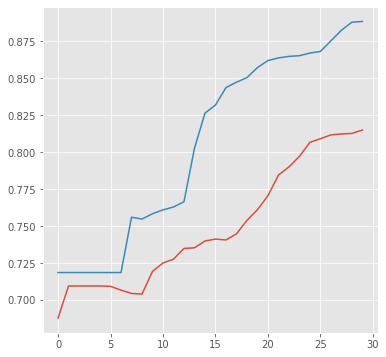

In [160]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(6, 6))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

In [169]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=nrofWords+1, output_dim=word_embedding_size, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32, return_sequences=True)),
    tf.keras.layers.Dense(nrofTags, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
])



In [170]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=30,
                    validation_split=0.5, verbose=1)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 1, 17)             598043    
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 1, 64)             3200      
_________________________________________________________________
dense_20 (Dense)             (None, 1, 17)             1105      
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 17)             0         
Total params: 602,348
Trainable params: 602,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
600/600 [==============================] - 3s 5ms/step - loss: 0.6051 - accuracy: 0.6091 - val_loss: 0.4632 - val_accuracy: 0.7185
Epoch 2/30
600/600 [==============================] - 3s 5ms/step - loss: 0.4682 - accuracy: 0.7094 - v

In [171]:
test_pred = model.predict(X_test, verbose=1)

idx2tag = {i: w for w, i in index_tag.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

300/300 [==============================] - 0s 972us/step


In [172]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      per       0.77      0.80      0.78       817
      org       0.47      0.48      0.47       555
      geo       0.71      0.82      0.76       627
      gpe       0.87      0.87      0.87       572
      tim       0.00      0.00      0.00       101
      art       0.00      0.00      0.00         2
      nat       0.00      0.00      0.00         1

micro avg       0.71      0.72      0.72      2675
macro avg       0.68      0.72      0.70      2675



In [173]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 71.7%
